In [17]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In this notebook, you will implement the forward longitudinal vehicle model. The model accepts throttle inputs and steps through the longitudinal dynamic equations. Once implemented, you will be given a set of inputs that drives over a small road slope to test your model.

The input to the model is a throttle percentage $x_\theta \in [0,1]$ which provides torque to the engine and subsequently accelerates the vehicle for forward motion. 

The dynamic equations consist of many stages to convert throttle inputs to wheel speed (engine -> torque converter -> transmission -> wheel). These stages are bundled together in a single inertia term $J_e$ which is used in the following combined engine dynamic equations.

\begin{align}
    J_e \dot{\omega}_e &= T_e - (GR)(r_{eff} F_{load}) \\ m\ddot{x} &= F_x - F_{load}
\end{align}

Where $T_e$ is the engine torque, $GR$ is the gear ratio, $r_{eff}$ is the effective radius, $m$ is the vehicle mass, $x$ is the vehicle position, $F_x$ is the tire force, and $F_{load}$ is the total load force. 

The engine torque is computed from the throttle input and the engine angular velocity $\omega_e$ using a simplified quadratic model. 

\begin{align}
    T_e = x_{\theta}(a_0 + a_1 \omega_e + a_2 \omega_e^2)
\end{align}

The load forces consist of aerodynamic drag $F_{aero}$, rolling friction $R_x$, and gravitational force $F_g$ from an incline at angle $\alpha$. The aerodynamic drag is a quadratic model and the friction is a linear model.

\begin{align}
    F_{load} &= F_{aero} + R_x + F_g \\
    F_{aero} &= \frac{1}{2} C_a \rho A \dot{x}^2 = c_a \dot{x}^2\\
    R_x &= N(\hat{c}_{r,0} + \hat{c}_{r,1}|\dot{x}| + \hat{c}_{r,2}\dot{x}^2) \approx c_{r,1} \dot{x}\\
    F_g &= mg\sin{\alpha}
\end{align}

Note that the absolute value is ignored for friction since the model is used for only forward motion ($\dot{x} \ge 0$). 
 
The tire force is computed using the engine speed and wheel slip equations.

\begin{align}
    \omega_w &= (GR)\omega_e \\
    s &= \frac{\omega_w r_e - \dot{x}}{\dot{x}}\\
    F_x &= \left\{\begin{array}{lr}
        cs, &  |s| < 1\\
        F_{max}, & \text{otherwise}
        \end{array}\right\} 
\end{align}

Where $\omega_w$ is the wheel angular velocity and $s$ is the slip ratio. 

We setup the longitudinal model inside a Python class below. The vehicle begins with an initial velocity of 5 m/s and engine speed of 100 rad/s. All the relevant parameters are defined and like the bicycle model, a sampling time of 10ms is used for numerical integration.

Implement the combined engine dynamic equations along with the force equations in the cell below. The function $\textit{step}$ takes the throttle $x_\theta$ and incline angle $\alpha$ as inputs and performs numerical integration over one timestep to update the state variables. Hint: Integrate to find the current position, velocity, and engine speed first, then propagate those values into the set of equations.

In [8]:
class Vehicle():
    def __init__(self):
        
        # State variables
        self.state = {}
        self.state['x'] = 0
        self.state['velocity'] = 5
        self.state['acceleration'] = 0
        self.state['angular_velocity_engine'] = 100
        self.state['angular_acceleration_engine'] = 0

        #Throttle to engine torque - Empirical coefficients fitted per engine
        self.A_0 = 400
        self.A_1 = 0.1
        self.A_2 = -0.0002
        
        # Gear ratio, effective radius, mass + inertia
        self.gear_ratio = 0.35
        self.radius_effective = 0.3
        self.moment_of_inertia_power_train = 10
        self.mass = 2000
        self.g = 9.81
        
        # Aerodynamic and friction coefficients
        self.coefficient_aero = 1.36
        self.coefficient_friction = 0.01
        
        # Tire force  - Linear Tire Model
        self.tire_stiffness_coefficient = 10000
        self.F_max = 10000
        
        self.time_delta = 0.01
    
    def reset(self):
        # reset state variables
        self.state['x'] = 0
        self.state['velocity'] = 5
        self.state['acceleration'] = 0
        self.state['angular_velocity_engine'] = 100
        self.state['angular_acceleration_engine'] = 0
    
    
    def step(self, throttle, alpha):
        Torque_engine = throttle * (self.A_0 + self.A_1*self.state['angular_velocity_engine'] + (self.A_2*self.state['angular_velocity_engine']**2))
        
        #Load Forces
        F_areo = self.coefficient_aero * (self.state['velocity']**2) # Aero Dynamics Drag
        R_x = self.coefficient_friction * self.state['velocity'] #Friction Drag
        F_g = self.mass * self.g * np.sin(alpha) #Gravity Drag
        F_load = F_areo + R_x + F_g
        
        
        #Angular acceleration
        self.state['angular_acceleration_engine'] = (Torque_engine - (self.gear_ratio*self.radius_effective)*F_load) / self.moment_of_inertia_power_train
        
        
        
        angular_velocity_wheel = self.gear_ratio * self.state['angular_velocity_engine']
        slip_ratio = (angular_velocity_wheel*self.radius_effective - self.state['velocity']) / self.state['velocity']
        
        if abs(slip_ratio) < 1:
            F_x = self.tire_stiffness_coefficient * slip_ratio
        else:
            F_x = self.F_max
        
        #force equation (acceleration) 
        self.state['acceleration'] = (F_x - F_load) / self.mass
        
        #update states using Euler Integration
        self.state['angular_velocity_engine'] += self.state['angular_acceleration_engine'] * self.time_delta
        self.state['velocity'] += self.state['acceleration'] * self.time_delta #Since v = a*t
        self.state['x'] += (self.state['velocity'] * self.time_delta) + (0.5 * self.state['acceleration'] * self.time_delta**2) #Since x = v*t + (1/2)*a*t^2

Using the model, we can send constant throttle inputs to the vehicle in the cell below. We will observe that the velocity converges to a fixed value based on the throttle input due to the aerodynamic drag and tire force limit. A similar velocity profile can be seen by setting a negative incline angle $\alpha$. In this case, gravity accelerates the vehicle to a terminal velocity where it is balanced by the drag force.

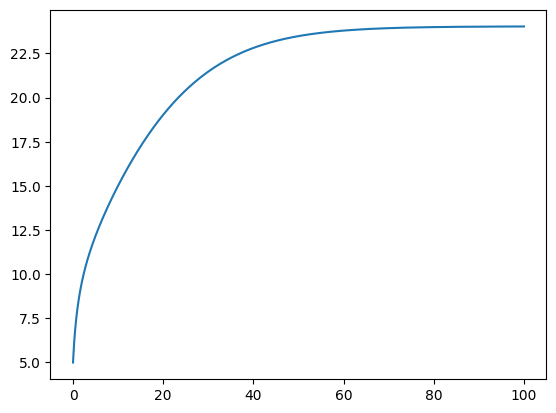

In [10]:
time_limit = 100
model = Vehicle()

t_data = np.arange(0,time_limit,model.time_delta)
v_data = np.zeros_like(t_data)

# throttle percentage between 0 and 1
throttle = 0.2

# incline angle (in radians)
alpha = 0

for i in range(t_data.shape[0]):
    v_data[i] = model.state['velocity']
    model.step(throttle, alpha)

plt.plot(t_data, v_data)
plt.show()

We will now drive the vehicle over a slope as shown in the diagram below.

![ramp](artifacts/ramp.png)

To climb the slope, a trapezoidal throttle input is provided for the next 20 seconds as shown in the figure below. 

![throttle](artifacts/throttle.png)

The vehicle begins at 20% throttle and gradually increases to 50% throttle. This is maintained for 10 seconds as the vehicle climbs the steeper slope. Afterwards, the vehicle reduces the throttle to 0.

In the cell below, implement the ramp angle profile $\alpha (x)$ and throttle profile $x_\theta (t)$ and step them through the vehicle dynamics. The vehicle position $x(t)$ is saved in the array $\text{x\_data}$. This will be used to grade your solution.

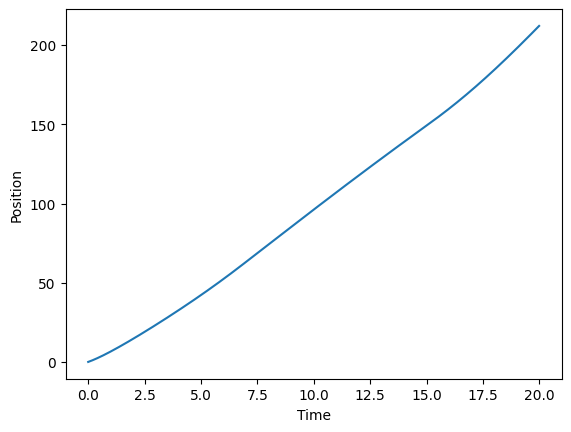

In [15]:
# reset the states
model.reset()

time_limit = 20
t_data = np.arange(0,time_limit,model.time_delta)
x_data = np.zeros_like(t_data)
w_e_data = np.zeros_like(t_data)

# Calculate angle
def angle(i, alpha, x):
    if x < 60:
        alpha[i] = np.arctan(3/60)
    elif x < 150:
        alpha[i] = np.arctan(9/90)
    else:
        alpha[i] = 0


throttle = np.zeros_like(t_data)
alpha = np.zeros_like(t_data)

#throttle depends on time and alpha depends on distance travelled (model.x)
for i in range(t_data.shape[0]):
    
    # Get Throttle and Angle 
    if t_data[i] < 5:
        throttle[i] = 0.2 + ((0.5 - 0.2)/5)*t_data[i]
        angle(i, alpha, model.state['x'])
    elif t_data[i] < 15:
        throttle[i] = 0.5
        angle(i, alpha, model.state['x'])
    else:
        throttle[i] = ((0 - 0.5)/(20 - 15))*(t_data[i] - 20)
        angle(i, alpha, model.state['x'])
    
    model.step(throttle[i], alpha[i])
    x_data[i] = model.state['x']
    v_data[i] = model.state['velocity']
    w_e_data[i] = model.state['angular_velocity_engine']


# Plot x vs t for visualization
plt.plot(t_data, x_data)
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()